<a href="https://colab.research.google.com/github/Deurru/DLND/blob/master/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [0]:
# Search for git repo and if not existing (! -e) clone it

!test ! -e deep-learning-v2-pytorch && git clone https://github.com/udacity/deep-learning-v2-pytorch.git

# Move DogClassProject contents to /content, so they are accessible

!test ! -e haarcascades/ && mv deep-learning-v2-pytorch/project-dog-classification/* /content 

# get all datasets

!test ! -e dogImages && wget -c https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

!test ! -e lfw && wget -c https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip

# unzip all datasets

!unzip -qq dogImages.zip
!unzip -qq lfw.zip

# remove unnecessary files, save space!

!test -e __MACOSX && rm -r __MACOSX*
!rm -r deep-learning-v2-pytorch
!rm -r dogImages.zip
!rm -r lfw.zip
!rm -r dog_app.ipynb
!rm -r README.md

Cloning into 'deep-learning-v2-pytorch'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1078 (delta 1), reused 2 (delta 0), pack-reused 1072
Receiving objects: 100% (1078/1078), 138.73 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (464/464), done.
Checking out files: 100% (270/270), done.
--2019-06-02 12:09:22--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.236.41
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.236.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  46.7MB/s    in 23s     

2019-06-02 12:09:45 (46.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

--2019-06-02 12:09:46--  https://s3-us-west-

In [0]:
# Imports here
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 2


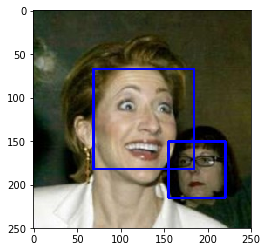

In [0]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
The algorithm detects 99% - 100% of the human images as having a human face, which is a good result. However, it also detects between 7% and 18% of the dog photos as having a human face in them. This is not a bad result, but should be improved.

In [0]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
true_humans = 0
false_humans = 0

for i in tqdm(human_files_short):
  if face_detector(i):
    true_humans+=1
    
for i in tqdm(dog_files_short):
  if face_detector(i):
    false_humans +=1

    
print("Humans detected as humans: ", true_humans)
print("Dogs detected as humans: ", false_humans)

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]

Humans detected as humans:  100
Dogs detected as humans:  15


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [0]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    print("moving to CUDA")
else:
  print("No CUDA. Training on CPU")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 123613217.57it/s]


moving to CUDA


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

(From the PyTorch docs)

"All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."

You can use the following transform to normalize:
```
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```



In [0]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    #Load image from path
    image = cv2.imread(img_path)
    
    #Create image transforms and normalization for input to pre-trained model
    img_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    #Normalized image, unsqueezed to add 1 at dim=0 (so it fits in the model)
    norm_image = img_transforms(image).unsqueeze(0)
    
    #check for CUDA, if true move img to where model is
    if use_cuda:
      norm_image.cuda()
    
    #get values for img from pre-trained model
    raw_output = VGG16(norm_image)
    
    #get max value by row and its index, throw away value and keep index
    _, index = torch.max(raw_output, 1)  
    return index
  # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    if index>= 151 and index <= 268:
      return True
    return False


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__  The function detects 0% - 1% of the human faces as dogs, and between 86% and 99% of the dogs as dogs.


In [0]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

false_dogs = 0
true_dogs = 0

VGG16.cpu()

for i in tqdm(human_files_short):
  if dog_detector(i):
    false_dogs+=1
    
for i in tqdm(dog_files_short):
  if dog_detector(i):
    true_dogs +=1

print("\nHumans detected as dogs: ", false_dogs)
print("Dogs detected as dogs: ", true_dogs)

100%|██████████| 100/100 [01:10<00:00,  1.52it/s]


Humans detected as dogs:  0
Dogs detected as dogs:  100


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [0]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# define image paths
train_path = "./dogImages/train"
valid_path = "./dogImages/valid"
test_path = "./dogImages/test"

# define transforms
train_transform = transforms.Compose([
    transforms.RandomApply([transforms.RandomRotation(30),
                            transforms.RandomResizedCrop(256),
                            transforms.RandomHorizontalFlip()
                           ], p=0.75),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
vt_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# define datasets
train_data = datasets.ImageFolder(train_path, transform = train_transform)
valid_data = datasets.ImageFolder(valid_path, transform = vt_transform)
test_data = datasets.ImageFolder(test_path, transform = vt_transform)

# define parameters for loaders. Makes tuning easier.
batch_size=20
shuffle=True
num_workers=0

# define loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           shuffle = shuffle)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                           shuffle = shuffle)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                          shuffle = shuffle)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
For the validation and test sets, where the importance is that the image is as close as possible to the real pictures the model could be asked to classify, I am only resizing the images. For that, I first transform the raw picture into a square picture of 255x255 squares, then I crop the center of the resulting picture into a 224x224 square. The input tensor should then be a (3, 224, 224) tensor, which is the minimum size PyTorch pre-trained models accept, according to the documentation.

On the other hand, it has been proven the models achieve a higher accuracy if the images in the training dataset are augmented through different transforms. For this, I have used a list of three transforms, randomly applied with a probability of 0.75 each. The transforms a) rotate the raw image by 30 degrees from its center, b) crop the image at a random size and aspect, then resize it to 256x256, and c) randomly flip the image along its horizontal axis.

In both the train and the validation/test datasets, the images are normalized according to the values specified in the documentation.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2),
                                      nn.Conv2d(16, 32, 3, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2),
                                      nn.Conv2d(32, 64, 3, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2))
        
        self.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(64 * 28 * 28, 500),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(500, 133))
        

    def forward(self, x):
        # Move input through features
        x = self.features(x)
        # Flatten features output for input into classifier
        x = x.view(-1, 64 * 28 * 28)
        # Move flattened image through classifier
        x = self.classifier(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=50176, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): Linear(in_features=500, out_features=133, bias=True)
  )
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I am using a set of 3 convolutional layers that increase the depth of the input image, with maxpooling layers between them to gradually reduce the x-y dimensionality of the image. This way, while the convolutional layers extract regional patterns in the image, the maxpooling layers discard non-relevant spatial info, such as background noise.

After each convolutional layer a ReLU activation function standardizes its output before it is introduced in the following MaxPooling layer.

The first convolutional layer of my CNN accepts a 224x224x3 image, and increases its depth to 16, while the first MaxPooling layer reduces its x-y dimensions to 112x112. The next set of Convolutional-MaxPooling increases the depth by a factor of 2, and reduces its dimensionality by the same factor, resulting in a 56x56x32 image tensor. The last set of Convolutional-MaxPooling layers outputs a 28x28x64 tensor.

This tensor is then flattened into a vector, and input into a classifier, which should output a score for each of the 133 classes of dogs we want to predict. This classifier has a dropout layer as gateway, with a 0.5 rate, then a Linear layer that accepts 64x28x28 features (50176) and outputs 500 features. After the linear layer comes a ReLU, then another dropout layer with the same rate,  and  the final Linear layer outputing 133 scores.

After training the whole CNN for 50 epochs (which took 77 minutes), with a CrossEntropyLoss as a criterion and an SGD optimizer with a learning rate of 0.01, I got 16% accuracy on the test set. Changing the optimizer to Adam and tuning the learning rate between 0.001 and 0.01 does not produce positive changes on the accuracy.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
import torch.optim as optim
# set loaders_scratch to loaders defined above
loaders_scratch = loaders

# set model_scratch to model defined above
model_scratch = model

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
#             train_loss += loss.item()*data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
#             valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [0]:
import time
# train the model (100 epochs)
# Start tracking training time
start = time.time()

model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, save_path='model_scratch.pt')

# calculate training time
end = time.time()
elapsed_time = end - start
print('Elapsed time: {:.1f}min {:.1f}sec'.format(elapsed_time//60, 
                                                 elapsed_time%60))
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.885601 	Validation Loss: 4.864032
Validation loss decreased (inf --> 4.864032).  Saving model ...
Epoch: 2 	Training Loss: 4.854524 	Validation Loss: 4.798359
Validation loss decreased (4.864032 --> 4.798359).  Saving model ...
Epoch: 3 	Training Loss: 4.793764 	Validation Loss: 4.692626
Validation loss decreased (4.798359 --> 4.692626).  Saving model ...
Epoch: 4 	Training Loss: 4.702479 	Validation Loss: 4.573348
Validation loss decreased (4.692626 --> 4.573348).  Saving model ...
Epoch: 5 	Training Loss: 4.627835 	Validation Loss: 4.467306
Validation loss decreased (4.573348 --> 4.467306).  Saving model ...
Epoch: 6 	Training Loss: 4.568903 	Validation Loss: 4.403824
Validation loss decreased (4.467306 --> 4.403824).  Saving model ...
Epoch: 7 	Training Loss: 4.516336 	Validation Loss: 4.367244
Validation loss decreased (4.403824 --> 4.367244).  Saving model ...
Epoch: 8 	Training Loss: 4.500637 	Validation Loss: 4.334420
Validation loss decreased (4.36724

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('./model_scratch.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.577298


Test Accuracy: 16% (139/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [0]:
## TODO: Specify data loaders
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# define image paths
train_path = "./dogImages/train"
valid_path = "./dogImages/valid"
test_path = "./dogImages/test"

# define transforms
train_transform = transforms.Compose([
    transforms.RandomApply([transforms.RandomRotation(30),
                            transforms.RandomResizedCrop(256),
                            transforms.RandomHorizontalFlip()
                           ], p=0.75),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
vt_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# define datasets
train_data = datasets.ImageFolder(train_path, transform = train_transform)
valid_data = datasets.ImageFolder(valid_path, transform = vt_transform)
test_data = datasets.ImageFolder(test_path, transform = vt_transform)

# define parameters for loaders. Makes tuning easier.
batch_size=20
shuffle=True
num_workers=0

# define loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           shuffle = shuffle)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                           shuffle = shuffle)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                          shuffle = shuffle)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [0]:
import torchvision.models as models
import torch.nn as nn

# ## TODO: Specify model architecture 
# Load pre-trained model
model_transfer = models.resnet152(pretrained=True, progress=True)

# Freeze features in Conv part of pre-trained model
for param in model_transfer.parameters():
    param.requires_grad = False

# Assign number of output nodes from last feature layer to a variable
in_feat_num = model_transfer.fc.in_features

# Specify new classifier
classifier = nn.Sequential(nn.Dropout(0.2),
                           nn.Linear(in_feat_num, 512),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512, 133))

# Swap pre-trained FC layer by new classifier 
model_transfer.fc = classifier
print(model_transfer)

# move the whole model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()
    print("moving to CUDA")

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:14<00:00, 16229887.30it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  I started out with a VGG16 pre-trained network, and the same classifier I used for my scratch model in Step 3: a double set of fully-connected layers, starting with a dropout layer with a rate of 0.5, and a Linear layer accepting a 64x28x28 input on the first set and a 500 input on the second set. I used Cross-Entropy Loss as a criterion, and SGD as optimizer with a learning rate of 0.001, and I got an accuracy on the test set of 68% after training for 10 epochs, which took 40 minutes.

I wanted to increase the accuracy and reduce the training time, so I changed the pre-trained network to ResNet152 due to its reduced size and its low error (21.69 Top-1 error, according to the documentation), as well as its suitability for image recognition. I kept the classifier architecture and the rest of the parameters, and trained for 15 epochs. It took 28 minutes, and the accuracy increased to 80%, but the loss started to increased after the 5th epoch, which meant the model started to overfit.

I tuned the parameters of the classifer: increased the number of features on the fully-connected layer to 512 (a power of 2) and changed the dropout rate to 0.2 in both dropout layers. I kept the criterion but changed the optimizer to Adam, after reading about its good results, but kept the same learning rate. Training for 15 epochs took 28 minutes, and the test accuracy increased to 87%. 

After this I kept the classifier set up, but added a LogSoftmax layer, as I wanted to change the criterion to NLLLoss. Training for 15 epochs took 26 minutes, but kept the accuracy at 87%. Training for 20 epochs did not improve the accuracy, and took an additional 8 minutes, so it did not seem a good efficiency tradeoff. 

After tweaking the parameters and trying out different criterion (Cross-Entropy/NLLLoss)-optimizer(SGD/ASGD/Adam/Adamax)-learning rate (0.001/0.5)-dropout(0.2/0.4) combinations, the best accuracy I got on the test set was 89%, after training for 20 epochs (33 mins) using a dropout rate of 0.2, Cross-Entropy Loss as the criterion, and the Adamax optimizer with a learning rate of 0.001.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
# Define criterion
criterion_transfer = nn.CrossEntropyLoss()

# Define optimizer
optimizer_transfer = optim.Adamax(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [0]:
import time

# set loaders and nr. epochs
loaders_transfer = loaders
n_epochs = 20

# Start tracking training time
start = time.time()

# train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, 
                       optimizer_transfer, criterion_transfer, use_cuda, 
                       save_path='./model_transfer.pt')

# calculate training time
end = time.time()
elapsed_time = end - start
print('Elapsed time: {:.1f}min {:.1f}sec'.format(elapsed_time//60, 
                                                 elapsed_time%60))

# load the model that got the best validation accuracy
# (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.691742 	Validation Loss: 1.827673
Validation loss decreased (inf --> 1.827673).  Saving model ...
Epoch: 2 	Training Loss: 1.942273 	Validation Loss: 0.894078
Validation loss decreased (1.827673 --> 0.894078).  Saving model ...
Epoch: 3 	Training Loss: 1.424666 	Validation Loss: 0.674561
Validation loss decreased (0.894078 --> 0.674561).  Saving model ...
Epoch: 4 	Training Loss: 1.236720 	Validation Loss: 0.558724
Validation loss decreased (0.674561 --> 0.558724).  Saving model ...
Epoch: 5 	Training Loss: 1.119600 	Validation Loss: 0.489851
Validation loss decreased (0.558724 --> 0.489851).  Saving model ...
Epoch: 6 	Training Loss: 1.036653 	Validation Loss: 0.457869
Validation loss decreased (0.489851 --> 0.457869).  Saving model ...
Epoch: 7 	Training Loss: 1.028337 	Validation Loss: 0.421634
Validation loss decreased (0.457869 --> 0.421634).  Saving model ...
Epoch: 8 	Training Loss: 0.945843 	Validation Loss: 0.411074
Validation loss decreased (0.42163

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [0]:
# Test Model
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.350609


Test Accuracy: 89% (752/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
# class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
class_names = [item[4:].replace("_", " ") for item in test_data.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path)
  
    vt_transform = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    #Display image
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    
    #Normalized image, unsqueezed to add 1 at dim=0 (so it fits in the model)
    norm_image = vt_transform(image).unsqueeze(0)
    
    #check for GPU. Move model and image to same processor
    if use_cuda:
      norm_image = norm_image.cuda()

    else:
      norm_image = norm_image.cpu()
      
    #Pass image to the model and get prediction
    raw_output = model_transfer(norm_image)
    
    #get max value by row and its index, throw away value and keep index
    _, index = torch.max(raw_output, 1)  
    return class_names[index]

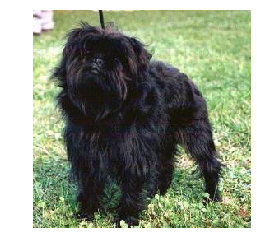

Affenpinscher


In [0]:
print(predict_breed_transfer("./dogImages/train/001.Affenpinscher/Affenpinscher_00010.jpg"))

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path) == True:
      print("Woof! It´s a %s " % predict_breed_transfer(img_path))
      
    elif face_detector(img_path) == True:
      print("This human looks like a %s " % predict_breed_transfer(img_path))
    
    else:
      image = Image.open(img_path)
      plt.imshow(image)
      plt.axis("off")
      plt.show()
      print("I don´t know what it is, but it doesn´t look like a dog!")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The output is better than I expected! My points of improvement would be:

1) The algorithm does not detect human faces when the image is too dark, has a non-human color, or the subject is too far away. This could be solved by training the face_detector with more images, better transforms and during more epochs.

2) The algorithm could show a standard dog image next to the image it is predicting, for quick verification of breed assigned in casi the image shows a dog, and for checking resemblance in case the image is of a human.

3) Because I did not want to draw upon the face_detector or the dog_detector codes, I coded the image processing and displaying function inside the run_app, for the cases the algorithm is not able to detect a dog or a human. This slows the performance of the algorithm and could be solved by integrating the face- and dog detection algorithms.

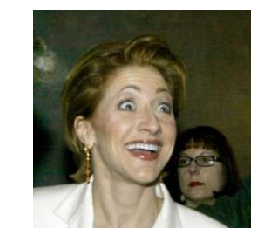

This human looks like a Poodle 


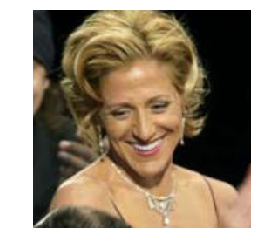

This human looks like a Silky terrier 


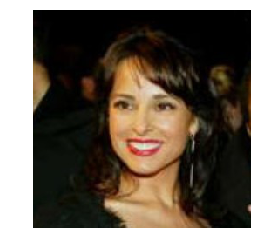

This human looks like a Cavalier king charles spaniel 


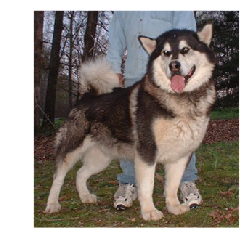

Woof! It´s a Alaskan malamute 


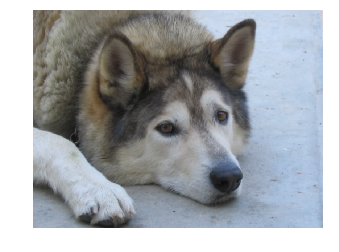

Woof! It´s a Alaskan malamute 


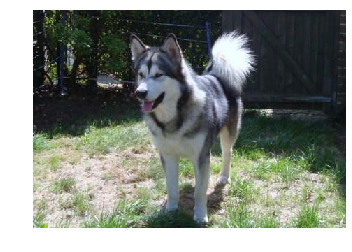

Woof! It´s a Alaskan malamute 


In [0]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

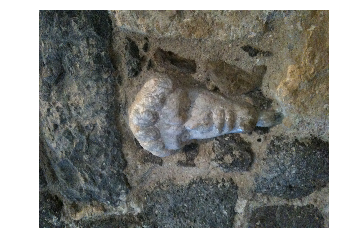

I don´t know what it is, but it doesn´t look like a dog!


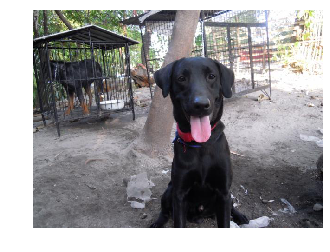

Woof! It´s a Labrador retriever 


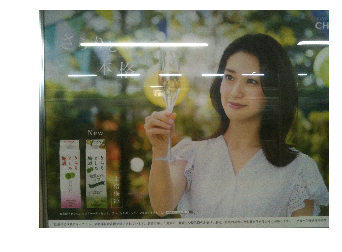

This human looks like a Norwegian lundehund 


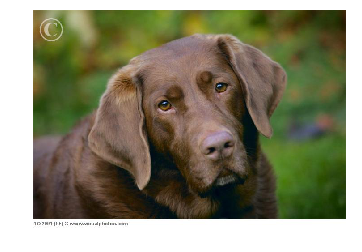

Woof! It´s a Labrador retriever 


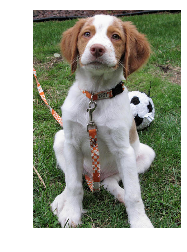

Woof! It´s a Brittany 


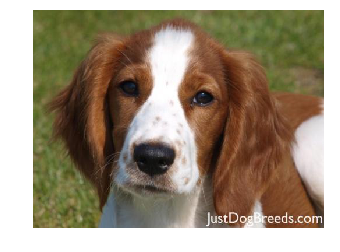

Woof! It´s a Irish red and white setter 


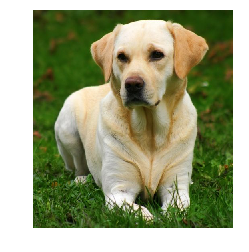

Woof! It´s a Labrador retriever 


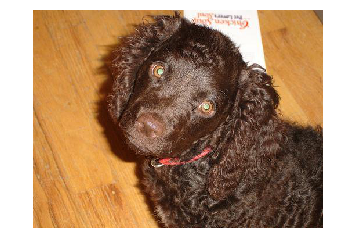

Woof! It´s a American water spaniel 


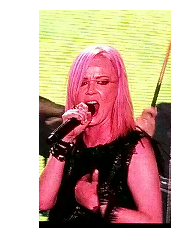

I don´t know what it is, but it doesn´t look like a dog!


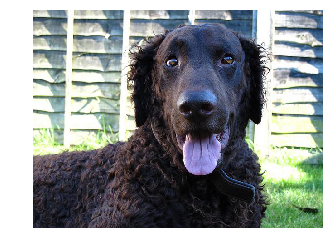

Woof! It´s a Curly-coated retriever 


In [0]:
test_files = np.array(glob("./images/*"))
for file in test_files:
  run_app(file)